# Software Developer career satisfaction detection - DEMO

Created by [Judit Acs](https://github.com/juditacs)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Load data

We use `pandas` for data loading and preprocessing.

[Data source (kaggle.com)](https://www.kaggle.com/stackoverflow/so-survey-2017)

In [2]:
df = pd.read_csv("data/stackoverflow/survey_results_public.csv")
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most answers are categorical:

In [3]:
df.groupby("ProgramHobby").size()

ProgramHobby
No                                            9787
Yes, I contribute to open source projects     3048
Yes, I program as a hobby                    24801
Yes, both                                    13756
dtype: int64

The table has 154 columns but many values are empty. These columns have the most non-empty values:

In [4]:
df.count().sort_values(ascending=False)[:20]

Respondent                51392
Professional              51392
FormalEducation           51392
EmploymentStatus          51392
University                51392
Country                   51392
ProgramHobby              51392
YearsProgram              51145
PronounceGIF              51008
HomeRemote                44008
MajorUndergrad            42841
CareerSatisfaction        42695
ClickyKeys                42046
YearsCodedJob             40890
JobSatisfaction           40376
CompanySize               38922
TabsSpaces                38851
CompanyType               38823
StackOverflowDescribes    36932
WorkStart                 36696
dtype: int64

## Feature extraction

We will use a few columns as features and `CareerSatisfaction` as the target variable:

In [5]:
feature_cols = ["Professional", "EmploymentStatus", "FormalEducation", "ProgramHobby", "HomeRemote",
                "IDE", "MajorUndergrad"]

# I do not include JobSatisfaction because it's too similar to the target variable
# Uncomment this line to include it in the features
# feature_cols.append("JobSatisfaction")

target_col = "CareerSatisfaction"

We filter all rows that do not define every feature column.

In [6]:
condition = (df[target_col].notnull())
for c in feature_cols:
    condition &= (df[c].notnull())
df = df[condition]
len(df)

27302

`CareerSatisfaction` values are distributed unevenly, so we may want to include fewer samples from very large classes. Uncomment the second to last line to filter these these samples:

In [7]:
minval = df.groupby(target_col).size().min() * 2

filt = None

for grouper, group in df.groupby(target_col):
    size = min(minval, len(group))
    if filt is None:
        filt = group.sample(size)
    else:
        filt = pd.concat((filt, group.sample(size)), axis=0)
#df = filt
len(df)

27302

## Convert categorical features to one-hot vectors

Categorical features need to be encoded as one-hot vectors instead of a single integer value. `LabelEncoder` does this automatically:

In [8]:
X = None

for col in feature_cols:
    mtx = LabelEncoder().fit_transform(df[col])
    maxval = np.max(mtx)
    feat_mtx = np.zeros((mtx.shape[0], maxval+1))
    feat_mtx[np.arange(feat_mtx.shape[0]), mtx] = 1
    if X is None:
        X = feat_mtx
    else:
        X = np.concatenate((X, feat_mtx), axis=1)

## Scale labels to [0, 1]

In [9]:
y = df[target_col].as_matrix() / 10

## Shuffle data

In [10]:
rand_mtx = np.random.permutation(X.shape[0])
train_split = int(X.shape[0] * 0.9)
train_indices = rand_mtx[:train_split]
test_indices = rand_mtx[train_split:]

X_train = X[train_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

## Define the model

In [11]:
input_layer = Input(batch_shape=(None, X.shape[1]))
layer = Dense(100, activation="sigmoid")(input_layer)
layer = Dropout(.2)(layer)
layer = Dense(100, activation="sigmoid")(input_layer)
layer = Dropout(.2)(layer)
layer = Dense(100, activation="sigmoid")(input_layer)
layer = Dropout(.2)(layer)
layer = Dense(1, activation="sigmoid")(layer)
model = Model(inputs=input_layer, outputs=layer)
model.compile("rmsprop", loss="mse")

## Train the model

In [12]:
ea = EarlyStopping(patience=2)
model.fit(X_train, y_train, epochs=100, batch_size=512,
          validation_split=.2, callbacks=[ea])

Train on 19656 samples, validate on 4915 samples
Epoch 1/100
19656/19656 [==============================] - 0s - loss: 0.0360 - val_loss: 0.0326
Epoch 2/100
19656/19656 [==============================] - 0s - loss: 0.0348 - val_loss: 0.0327
Epoch 3/100
19656/19656 [==============================] - 0s - loss: 0.0344 - val_loss: 0.0324
Epoch 4/100
19656/19656 [==============================] - 0s - loss: 0.0338 - val_loss: 0.0329
Epoch 5/100
19656/19656 [==============================] - 0s - loss: 0.0331 - val_loss: 0.0324
Epoch 6/100
19656/19656 [==============================] - 0s - loss: 0.0327 - val_loss: 0.0327


## Predict labels

In [13]:
pred = model.predict(X_test)

## Compute loss

We compute it manually.

In [14]:
np.sqrt(np.mean(pred - y_test) ** 2)

0.016742466623116976

### What would be the loss if we guessed 0.5 every time?

It is always a good idea to perform sanity checks. Did our model learn anything more useful than a trivial solution or a random generator?

In [15]:
np.sqrt(np.mean(.5*np.ones(y_test.shape[0]) - y_test) ** 2)

0.24335408275357012

## Histogram of predictions vs. gold labels

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b4c61ec50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7b0bc9c438>]], dtype=object)

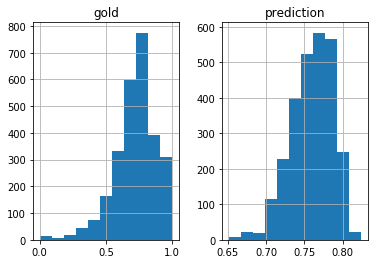

In [16]:
prediction = pd.DataFrame({'gold': y_test, 'prediction': pred[:, 0]})
prediction['diff'] = prediction.gold - prediction.prediction
prediction.hist(['gold', 'prediction'], bins=11)

## Plot labels for 20 random samples

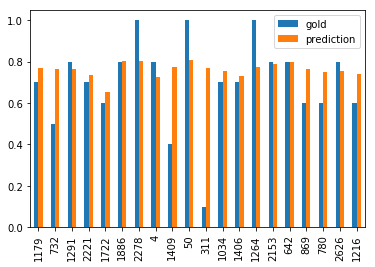

In [17]:
prediction.sample(20).plot(y=['gold', 'prediction'], kind='bar')

## How similar are the answers for JobSafisfaction and CareerSatisfaction?

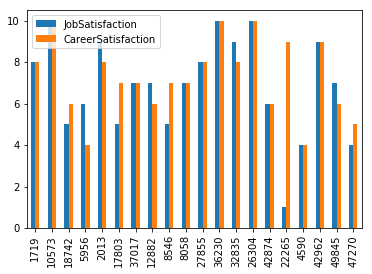

In [18]:
df[['JobSatisfaction', 'CareerSatisfaction']].sample(20).plot(kind='bar')

## They are very similar

Try training the model with and without this feature.

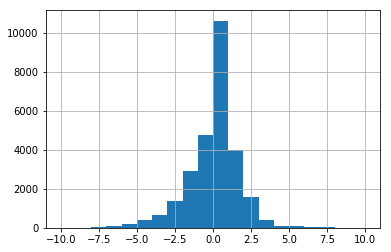

In [19]:
(df['JobSatisfaction'] - df['CareerSatisfaction']).hist(bins=20)